# **Next Word Prediction :-**

problem statement - perform nlp and develop model to predict next word in the sentence

# **Setting up Directory**

In [ ]:
file_path = '/content/human_chat.txt'

with open(file_path, "r") as file:
  lines = file.readlines()

In [ ]:
%%capture
!pip install demoji

In [ ]:
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

import re
import string
from bs4 import BeautifulSoup
import demoji
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **Preprocessing**

In [ ]:
lines[:50]

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n',
 'Human 2: Which holiday was that?\n',
 'Human 1: I think it was Australia\n',
 'Human 2: Do you still talk to the people you met?\n',
 "Human 1: Not really. The interactions are usually short-lived but it's fascinating to learn where people are coming from and what matters to them\n",
 'Human 2: Yea, me too. I feel like God often puts strangers in front of you, and gives you an opportunity to connect with them in that moment in deeply meaningful ways. Do you ever feel like you know things about strangers without them telling you?\n',
 'Human 1: what do you mean?\n',
 'Human 2: I think it\'s like a 6th sense, often seen as "cold readings" to people, but can be remarkably accurate. I once sat next to a man in a coffee and I felt

In [ ]:
len(lines)

1495

In [ ]:
def preprocess_text(text):
        # Remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()

        # Removing Punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        #p = inflect.engine() #101
        demoji.download_codes()
        # Remove emojis
        text = demoji.replace(text, "")

        # Remove new line character
        text = text.replace('\n','')

        # Remove mentions of "Human 1" and "Human 2"
        text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

        # Remove special characters, keeping only alphabetic and spaces
        text = re.sub(r'[^a-zA-Z\s]', r' ', text)

        # Replace specific unicode spaces with standard spaces and trim
        text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

        # Removing white spaces
        text = re.sub(r'\s+',r' ',text)

        # Lower case every word
        text = text.lower()

        return text

In [ ]:
preprocessed_lines = [preprocess_text(line) for line in lines]

In [ ]:
preprocessed_lines = [line for line in preprocessed_lines if line != '']

In [ ]:
len(preprocessed_lines)

1492

In [ ]:
preprocessed_lines[:20]

['hi',
 'what is your favorite holiday',
 'one where i get to meet lots of different people',
 'what was the most number of people you have ever met during a holiday',
 'hard to keep a count maybe',
 'which holiday was that',
 'i think it was australia',
 'do you still talk to the people you met',
 'not really the interactions are usually shortlived but its fascinating to learn where people are coming from and what matters to them',
 'yea me too i feel like god often puts strangers in front of you and gives you an opportunity to connect with them in that moment in deeply meaningful ways do you ever feel like you know things about strangers without them telling you',
 'what do you mean',
 'i think its like a th sense often seen as cold readings to people but can be remarkably accurate i once sat next to a man in a coffee and i felt a pain in my back i asked the stranger if he had a pain it turns out that he did in the exact spot and said he pulled a muscle while dancing at a party i had

# **Tokenization**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")

In [ ]:
tokenizer.fit_on_texts(preprocessed_lines)

### **Vocabulary**

In [ ]:
word_to_idx = tokenizer.word_index
word_to_idx

{'<OOV>': 1,
 'i': 2,
 'you': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'it': 7,
 'of': 8,
 'and': 9,
 'is': 10,
 'do': 11,
 'that': 12,
 'in': 13,
 'what': 14,
 'for': 15,
 'have': 16,
 'like': 17,
 'are': 18,
 'im': 19,
 'its': 20,
 'but': 21,
 'so': 22,
 'good': 23,
 'about': 24,
 'my': 25,
 'hi': 26,
 'your': 27,
 'how': 28,
 'be': 29,
 'with': 30,
 'not': 31,
 'on': 32,
 'was': 33,
 'think': 34,
 'going': 35,
 'oh': 36,
 'just': 37,
 'haha': 38,
 'up': 39,
 'this': 40,
 'time': 41,
 'at': 42,
 'we': 43,
 'me': 44,
 'nice': 45,
 'too': 46,
 'some': 47,
 'there': 48,
 'work': 49,
 'very': 50,
 'can': 51,
 'thats': 52,
 'all': 53,
 'really': 54,
 'as': 55,
 'would': 56,
 'day': 57,
 'been': 58,
 'yeah': 59,
 'lot': 60,
 'did': 61,
 'fun': 62,
 'any': 63,
 'great': 64,
 'yes': 65,
 'will': 66,
 'pretty': 67,
 'well': 68,
 'if': 69,
 'out': 70,
 'get': 71,
 'dont': 72,
 'one': 73,
 'know': 74,
 'they': 75,
 'more': 76,
 'go': 77,
 'cool': 78,
 'from': 79,
 'or': 80,
 'no': 81,
 'am': 82,
 'muc

In [ ]:
unique_words = len(tokenizer.word_index)
unique_words

2768

In [ ]:
len(word_to_idx)

2768

In [ ]:
input_sequences = []
for sentence in preprocessed_lines:
  tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]

  for i in range(1,len(tokenized_sentence)):
    input_sequences.append(tokenized_sentence[:i+1])

In [ ]:
input_sequences

[[14, 10],
 [14, 10, 27],
 [14, 10, 27, 120],
 [14, 10, 27, 120, 304],
 [73, 88],
 [73, 88, 2],
 [73, 88, 2, 71],
 [73, 88, 2, 71, 4],
 [73, 88, 2, 71, 4, 221],
 [73, 88, 2, 71, 4, 221, 273],
 [73, 88, 2, 71, 4, 221, 273, 8],
 [73, 88, 2, 71, 4, 221, 273, 8, 205],
 [73, 88, 2, 71, 4, 221, 273, 8, 205, 96],
 [14, 33],
 [14, 33, 5],
 [14, 33, 5, 141],
 [14, 33, 5, 141, 637],
 [14, 33, 5, 141, 637, 8],
 [14, 33, 5, 141, 637, 8, 96],
 [14, 33, 5, 141, 637, 8, 96, 3],
 [14, 33, 5, 141, 637, 8, 96, 3, 16],
 [14, 33, 5, 141, 637, 8, 96, 3, 16, 131],
 [14, 33, 5, 141, 637, 8, 96, 3, 16, 131, 393],
 [14, 33, 5, 141, 637, 8, 96, 3, 16, 131, 393, 255],
 [14, 33, 5, 141, 637, 8, 96, 3, 16, 131, 393, 255, 6],
 [14, 33, 5, 141, 637, 8, 96, 3, 16, 131, 393, 255, 6, 304],
 [183, 4],
 [183, 4, 394],
 [183, 4, 394, 6],
 [183, 4, 394, 6, 638],
 [183, 4, 394, 6, 638, 168],
 [107, 304],
 [107, 304, 33],
 [107, 304, 33, 12],
 [2, 34],
 [2, 34, 7],
 [2, 34, 7, 33],
 [2, 34, 7, 33, 395],
 [11, 3],
 [11, 3, 20

In [ ]:
len(input_sequences)

17815

In [ ]:
max_len = max([len(x) for x in input_sequences])
max_len

151

# **Padding for equal dimension**

In [ ]:
padded_input_sequences = pad_sequences(input_sequences, maxlen = max_len, padding='pre')

In [ ]:
padded_input_sequences

array([[  0,   0,   0, ...,   0,  13,   9],
       [  0,   0,   0, ...,  13,   9,  26],
       [  0,   0,   0, ...,   9,  26, 119],
       ...,
       [  0,   0,   0, ...,   3,  33,  23],
       [  0,   0,   0, ...,  33,  23, 537],
       [  0,   0,   0, ...,  23, 537,   6]], dtype=int32)

In [ ]:
padded_input_sequences.shape

(17815, 151)

# **Preparing Data**

In [ ]:
X = padded_input_sequences[:,:-1]
y = padded_input_sequences[:,-1]

In [ ]:
X.shape

(17815, 150)

In [ ]:
y.shape

(17815,)

In [ ]:
np.save('y.npy' , y)

In [ ]:
y = to_categorical(y,num_classes=unique_words+1)

In [ ]:
y.shape

(17815, 2769)

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **Building LSTM model**

In [ ]:
model = Sequential()
model.add(Embedding(unique_words, output_dim = 100, input_length=150))
# Build the model with an input shape
model.build((None, 150))
model.add(LSTM(150))
model.add(Dense(unique_words+1, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 100)            │         276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2769)                │         418,119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 845,519 (3.23 MB)

 Trainable params: 845,519 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X,y,epochs=50)

Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.0367 - loss: 6.6893
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0529 - loss: 6.0520
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0901 - loss: 5.7023
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1166 - loss: 5.2729
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1412 - loss: 4.9574
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.1583 - loss: 4.6774
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1866 - loss: 4.3738
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.2039 - loss: 4.1234
Epoch 9/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2270 - loss: 3.8752
Epoch 10/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2712 - loss: 3.5990
Epoch 11/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3059 - loss: 3.3614
Epoch 12/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 

# **Plotting Accuracy and loss**

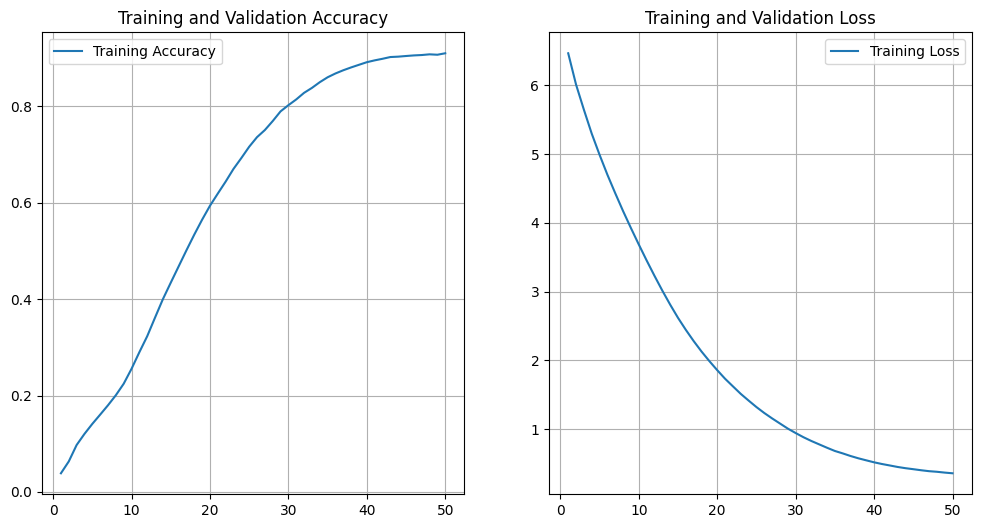

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = np.arange(1, len(acc)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

### **Saving the model**

In [ ]:
model_path = 'lstm_model.keras'
model.save(model_path)

# **Predict the Next Word**

In [ ]:
def predict_next_word(model ,input_text, word_to_idx):
  for i in range(5):
    # tokenize
    token_text = tokenizer.texts_to_sequences([input_text])[0]
    # padding
    padded_token_text = pad_sequences([token_text], maxlen=151, padding='pre')
    # predict
    prediction = model.predict(padded_token_text , verbose = 0) # To suppress the output of Keras during predictions
    pos = np.argmax(prediction)

    for word,index in word_to_idx.items():
      if index == pos:
        input_text = input_text + " " + word
        print(input_text)

In [ ]:
input_text = "what was the most number of people"

In [ ]:
predict_next_word(model, input_text, word_to_idx)

what was the most number of people you
what was the most number of people you have
what was the most number of people you have ever
what was the most number of people you have ever met
what was the most number of people you have ever met during


In [ ]:
corpus =  " ".join([line for line in preprocessed_lines])

In [ ]:
corpus

'hi what is your favorite holiday one where i get to meet lots of different people what was the most number of people you have ever met during a holiday hard to keep a count maybe which holiday was that i think it was australia do you still talk to the people you met not really the interactions are usually shortlived but its fascinating to learn where people are coming from and what matters to them yea me too i feel like god often puts strangers in front of you and gives you an opportunity to connect with them in that moment in deeply meaningful ways do you ever feel like you know things about strangers without them telling you what do you mean i think its like a th sense often seen as cold readings to people but can be remarkably accurate i once sat next to a man in a coffee and i felt a pain in my back i asked the stranger if he had a pain it turns out that he did in the exact spot and said he pulled a muscle while dancing at a party i had never met the man before and never saw him a